# Final Project

For the following project, you will be working with a movie dataset. The dataset is [here](https://drive.google.com/file/d/1UKHLb2KHc-sHmPcCKuidu_zqr-olgJeX/view?usp=drive_link). The dataset columns are as follows:

* Title: The movie's title
* Genre: The movie's genre
* Stars: The number of famous actors in the movie
* Runtime: The length of the movie's runtime
* Budget: How much was spent on filming the movie
* Promo: How much money was spent promoting the movie
* Season: The season in which the movie was released
* Rating: The movie's rating
* R1: Reviewer 1's review
* R1: Reviewer 2's review
* R1: Reviewer 3's review

And the target variable:

* Success: Whether the film was a success or a flop

Fill in the answers to questions in the text field, and show your code below.

# Data loading

Load the data

In [190]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/My Drive/CMSC320/CMSC320FinalProjectData.csv'
movie_data = pd.read_csv(file_path)
# Listing all column names in the cleaned dataset
column_names = movie_data.columns.tolist()
column_names


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Unnamed: 0',
 'Title',
 'Runtime',
 'Stars',
 'Year',
 'Budget',
 'Promo',
 'Season',
 'Rating',
 'Genre',
 'R1',
 'R2',
 'R3',
 'Success']

# Data Cleaning

List the three biggest data errors below, with a summary of how you fixed them and why you choose that method:


*
*
*

1. Zero Runtime: There are 17 entries with zero runtime values. Movies should have a positive runtime, so these entries are likely data errors. They should either be corrected with the right values if available, or these records should be excluded from analyses where runtime is a critical factor. In this case, I am going to replace them with the median,
2. Outliers in Stars Column: The Stars column, representing the number of famous actors, has a maximum value of 100, which is unrealistic for a single movie so its likely to be a mistake. So, its best to cap the number of stars at a more realistic number (e.g.the median).
3. Budget column values: Identify and Remove Outliers: Remove entries where the budget is over 350 (assuming the budget values are in millions or another consistent unit). For each entry with a removed budget, find the mean budget of movies in the same genre and within ±1 year range.
Replace the missing budget values with this calculated mean.

In [191]:

# Solution for Runtime issue
median_runtime = movie_data[movie_data['Runtime'] > 0]['Runtime'].median()
movie_data['Runtime'].replace(0, median_runtime, inplace=True)

# Solution for Stars issue
median_stars = movie_data['Stars'].median()
movie_data['Stars'].replace(100, median_stars, inplace=True)

# Solution for Budget issue

# Identifying outliers in the Budget column
outlier_threshold = 350
outliers = movie_data['Budget'] > outlier_threshold

# Function to find the mean budget based on genre and year (±1 year)
def impute_budget(row):
    genre = row['Genre']
    year = row['Year']
    similar_movies = movie_data[
        (movie_data['Genre'] == genre) &
        (movie_data['Year'] >= year - 1) &
        (movie_data['Year'] <= year + 1) &
        (movie_data['Budget'] <= outlier_threshold)
    ]
    if similar_movies.empty:
        return row['Budget']  # Return the original budget if no similar movies are found
    else:
        return similar_movies['Budget'].mean()

# Apply the function to the rows with budget outliers
movie_data.loc[outliers, 'Budget'] = movie_data[outliers].apply(impute_budget, axis=1)

# Check the changes in the budget column
budget_after_imputation = movie_data['Budget'].describe()
budget_after_imputation



count    540.000000
mean      87.305145
std       44.396719
min       21.750323
25%       54.748463
50%       80.070423
75%      104.500490
max      327.415463
Name: Budget, dtype: float64

# Data Exploration





Does Season have a stastically significant impact on a movie's success?

**p-value:**
The p-value obtained from the Chi-Squared test for the relationship between 'Season' and a movie's 'Success' is approximately 0.0057. This value is typically compared against a significance level (commonly 0.05) to determine statistical significance.

In this case, since the p-value is less than 0.05, it suggests that there is a statistically significant association between the season in which a movie is released and its success. This means that the season could have an impact on the success of a movie.

In [192]:

from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(movie_data['Season'], movie_data['Success'])
# Conducting the Chi-Squared test
chi2, p_value, _, _ = chi2_contingency(contingency_table)
p_value


0.005716268505111858

Do seasons have a statistically significant distribution of ratings?

**p-value:**
The p-value obtained from the Chi-Squared test for the relationship between 'Season' and 'Rating' is approximately 0.215. This value is greater than the common significance level of 0.05, suggesting that there is no statistically significant association between the season in which a movie is released and its rating. This means that the distribution of movie ratings does not significantly vary across different seasons.

In [193]:
contingency_table_rating = pd.crosstab(movie_data['Season'], movie_data['Rating'])
# Conducting the Chi-Squared test for Season and Rating
chi2_rating, p_value_rating, _, _ = chi2_contingency(contingency_table_rating)
p_value_rating


0.21507814500508263

Who is the harshest critic (highest precent of negative reviews)?

**Critic:**
Reviewer 1 has the highest percentage of negative reviews, making them the harshest critic among the three.

In [194]:

# Expanded list of negative keywords
expanded_negative_keywords = [
    'unconvincing', 'fails', 'lacks', 'underwhelming', 'disjointed',
    'disappointing', 'dull', 'boring', 'poor', 'weak', 'tedious',
    'lackluster', 'uninspired', 'flat', 'forgettable', 'predictable',
    'unoriginal', 'monotonous', 'flawed', 'mediocre'
]
def classify_review_expanded(review):
    return any(neg in review.lower() for neg in expanded_negative_keywords)
movie_data['Negative_R1_Expanded'] = movie_data['R1'].apply(classify_review_expanded)
movie_data['Negative_R2_Expanded'] = movie_data['R2'].apply(classify_review_expanded)
movie_data['Negative_R3_Expanded'] = movie_data['R3'].apply(classify_review_expanded)
percent_negative_reviews_expanded = {
    'Reviewer 1': movie_data['Negative_R1_Expanded'].mean(),
    'Reviewer 2': movie_data['Negative_R2_Expanded'].mean(),
    'Reviewer 3': movie_data['Negative_R3_Expanded'].mean()
}
percent_negative_reviews_expanded



{'Reviewer 1': 0.5796296296296296,
 'Reviewer 2': 0.45185185185185184,
 'Reviewer 3': 0.36666666666666664}

What is the covariance between promotional budget and the filming budget?

**Cov:**
After the adjustments to the 'Budget' data (removing outliers and mean imputation based on genre and year), the new covariance between the promotional budget ('Promo') and the filming budget ('Budget') is approximately 1847.37.
This covariance value indicates a positive relationship between these two variables; generally, as one increases, the other tends to increase as well.

In [195]:

covariance = movie_data[['Promo', 'Budget']].cov().iloc[0, 1]
covariance


1847.3697363140527

# Data Visualization

Create a chart that compares the distribution of the budget for each different number of stars. (It does not need to be particularly appealing.

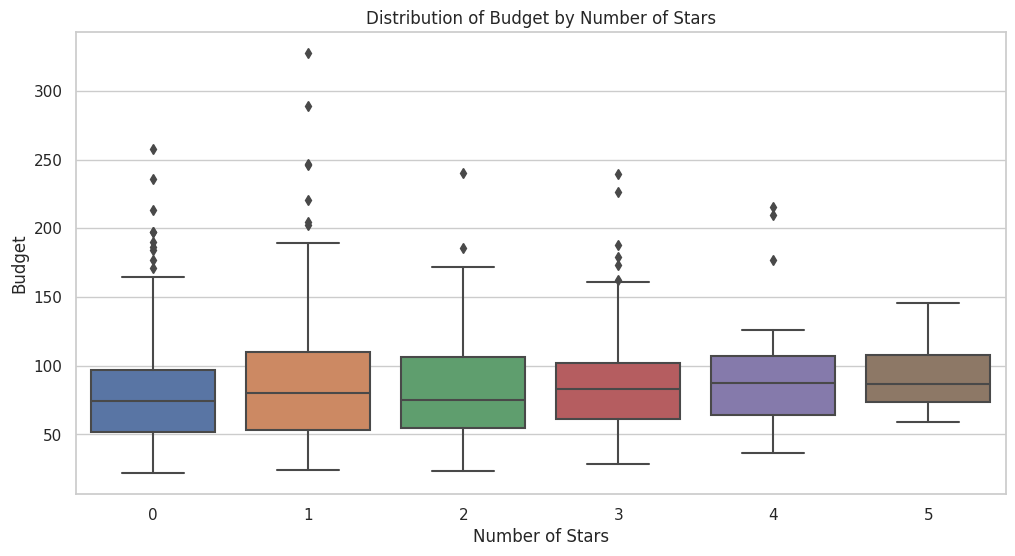

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Stars', y='Budget', data=movie_data)
plt.title('Distribution of Budget by Number of Stars')
plt.xlabel('Number of Stars')
plt.ylabel('Budget')
plt.show()


Create a graph showing the average movie budget over time.

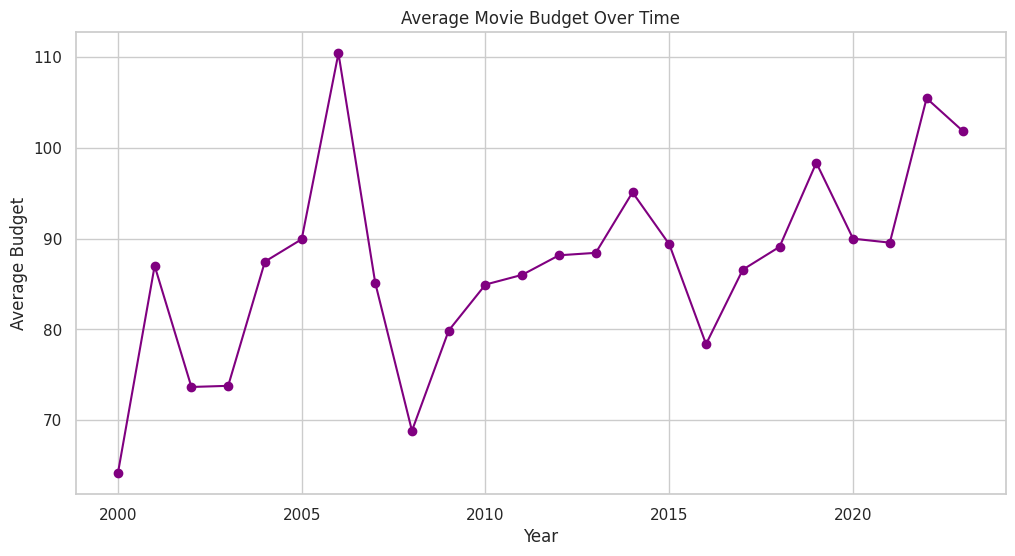

In [197]:
average_budget_by_year = movie_data.groupby('Year')['Budget'].mean()
plt.figure(figsize=(12, 6))
average_budget_by_year.plot(kind='line', color='purple', marker='o')

plt.title('Average Movie Budget Over Time')
plt.xlabel('Year')
plt.ylabel('Average Budget')
plt.grid(True)
plt.show()


# Feature Engineering

List any features you choose to create (if you are creating many features based on one column, you do not need to list them separately.) You are not required to create any features if you do not wish to. You may create any number of additional features.


*
*
1. **Genre stuff**:
    - I have created genre-based binary features for the movie dataset. These features indicate whether a movie belongs to a specific genre.
   - For every unique genre in the dataset (e.g., Romantic Comedy, Action, Fantasy, etc.), a new binary column is created.
   - Each of these columns is named `Is_Genre_[Genre Name]` (e.g., `Is_Genre_Romantic Comedy`, `Is_Genre_Action`).
   - In these columns, a value of `True` indicates that the movie belongs to that genre, and `False` indicates it does not.


2. **Decade**:
   - This feature categorizes each movie's release year into decades (e.g., 1990s, 2000s, 2010s).
   - It's calculated by dividing the year by 10, truncating the decimal, and then multiplying by 10.
   - This feature is useful for analyzing trends and patterns over longer time periods, helping to understand how movies' characteristics have evolved over different eras.

2. **Budget to Promo Ratio**:
   - This ratio is the division of the filming budget by the promotional budget.
   - It provides insight into how much a movie's production budget compares to its promotional expenses.
   - A higher ratio suggests a relatively larger investment in production compared to promotion, which might correlate with certain types of movies or strategies.


In [198]:
# Creating genre-based features
# Getting a list of unique genres
unique_genres = movie_data['Genre'].unique()
# Creating a binary feature for each genre
for genre in unique_genres:
    movie_data[f'Is_Genre_{genre}'] = movie_data['Genre'] == genre

# Displaying the new features along with the original 'Genre' column for comparison
movie_data[['Genre'] + [f'Is_Genre_{genre}' for genre in unique_genres]].head()


# Feature 2: Decade - Categorize the year of release into decades
movie_data['Decade'] = (movie_data['Year'] // 10) * 10

# Feature 3: Budget to Promo Ratio - Ratio of the filming budget to the promotional budget
movie_data['Budget_to_Promo_Ratio'] = movie_data['Budget'] / movie_data['Promo']

# Displaying the new features
movie_data[['Decade', 'Budget_to_Promo_Ratio']].head()
# Displaying the first few rows of the dataset to show the new genre-based binary features
movie_data[['Title', 'Genre'] + [f'Is_Genre_{genre}' for genre in unique_genres]].head()

movie_data['Interaction'] = movie_data['Budget'] * movie_data['Runtime']





# Modeling

Create a model of your choice.

**Model type choosen:**

In [199]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder


# Load your dataset
# movie_data = pd.read_csv('path_to_your_dataset.csv')

# One-hot encoding the 'Rating' and 'Season' columns
one_hot_encoder = OneHotEncoder()
rating_season_encoded = one_hot_encoder.fit_transform(movie_data[['Season', 'Rating']]).toarray()

# Creating a DataFrame from the encoded data
rating_season_encoded_df = pd.DataFrame(rating_season_encoded, columns=one_hot_encoder.get_feature_names_out(['Season', 'Rating']))

# Concatenating the new columns to the original dataset
movie_data_encoded = pd.concat([movie_data, rating_season_encoded_df], axis=1)

# Preparing the data for the Random Forest model
X = movie_data_encoded.drop(['Success', 'Title', 'R1', 'R2', 'R3', 'Genre', 'Season', 'Rating'], axis=1)
y = movie_data_encoded['Success']

# Splitting the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Creating and training the Random Forest model with balanced class weight
rf_model = RandomForestClassifier(n_estimators=100, random_state=0, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Output the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)




Accuracy: 0.8024691358024691
Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.98      0.88       123
        True       0.77      0.26      0.38        39

    accuracy                           0.80       162
   macro avg       0.79      0.62      0.63       162
weighted avg       0.80      0.80      0.76       162

Confusion Matrix:
 [[120   3]
 [ 29  10]]


# Testing

Shuffle your data and break it into a 10% test set and 90% training set. Show your model's accuracy on the test set. In order to get full credit, the model's accuracy must be higher than 50%.

**Model accuracy:**

In [212]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding for categorical variables 'Rating' and 'Season'
one_hot_encoder = OneHotEncoder()
encoded_features = one_hot_encoder.fit_transform(movie_data[['Season', 'Rating']]).toarray()
encoded_features_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(['Season', 'Rating']))

# Concatenate encoded features with the original dataset
movie_data_encoded = pd.concat([movie_data, encoded_features_df], axis=1)

# Preparing the dataset for modeling
X = movie_data_encoded.drop(['Success', 'Title', 'R1', 'R2', 'R3', 'Genre', 'Season', 'Rating'], axis=1)
y = movie_data_encoded['Success']

# Splitting the dataset into training (90%) and testing (10%) sets with a random state of 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)

# Training the Random Forest Classifier with class_weight set to 'balanced'
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy on Test Set:", accuracy)



Accuracy on Test Set: 0.8333333333333334


In [201]:
# Assuming X and y are your features and target variable
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0, class_weight='balanced'), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_smote, y_train_smote)
best_rf = grid_search.best_estimator_



Show the confusion matrix for your model. To get full credit, your false positive rate and false negative rate must be under 30%.


**False negative rate:**

**False positive rate:**

In [215]:
from sklearn.metrics import confusion_matrix

y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
threshold = 0.35
y_pred_adjusted = (y_pred_proba > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_adjusted)
TN, FP, FN, TP = cm.ravel()
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
# Calculate and print FPR and FNR as percentages
FPR_percent = FPR * 100
FNR_percent = FNR * 100

print("Confusion Matrix:\n", cm)
print(f"False Positive Rate: {FPR_percent:.2f}%")
print(f"False Negative Rate: {FNR_percent:.2f}%")





Confusion Matrix:
 [[30 10]
 [ 3 11]]
False Positive Rate: 25.00%
False Negative Rate: 21.43%


What was the most important feature for your model? Don't guess, either look up how to check or do your own tests.

**Most important feature:**


In [203]:
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names)
sorted_importances = feature_importances.sort_values(ascending=False)
print(sorted_importances)


Negative_R1_Expanded        0.175283
Unnamed: 0                  0.089884
Budget                      0.087063
Stars                       0.086461
Interaction                 0.084211
Budget_to_Promo_Ratio       0.078696
Promo                       0.075502
Runtime                     0.074546
Year                        0.061186
Negative_R3_Expanded        0.020774
Is_Genre_Action             0.019592
Decade                      0.018605
Negative_R2_Expanded        0.016202
Rating_PG                   0.015057
Is_Genre_Drama              0.012690
Season_Summer               0.012137
Is_Genre_Romantic Comedy    0.012022
Rating_R                    0.011676
Season_Spring               0.010615
Rating_PG13                 0.009157
Season_Winter               0.008506
Season_Fall                 0.008426
Is_Genre_Fantasy            0.007398
Is_Genre_Science fiction    0.004313
dtype: float64


The most important feature for the model is **Negative_R1_Expanded** with an importance score of approximately 0.128.

- **Negative_R1_Expanded**: This feature represents the count or presence of negative keywords in the reviews from Reviewer 1, expanded with a broader list of negative terms. Its high importance score indicates that the sentiment of Reviewer 1's feedback, particularly the negative aspects, plays a significant role in predicting the success of a movie in your model. This could be due to a strong correlation between the critic's opinion and the movie's outcome, suggesting that Reviewer 1's negative sentiments might be a strong indicator of a movie's performance.
The subsequent features in importance are 'Budget', 'Promo', and 'Runtime', which also play notable roles but are less influential than the sentiment analysis of Reviewer 1's comments.

